### Load modules

In [128]:
# basic modules
import pandas as pd
import requests
import re
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
import copy
import numpy as np
from scipy.stats import linregress

# text rendering of plot labels
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

### Define function for downloading data

In [5]:
units = {}
units['PM2.5'] = '\mu g/m3'
units['CO'] = 'pptm'
units['O3'] = 'ppb'
units['NO'] = 'ppb'
units['NO2'] = 'ppb'
units['NOx'] = 'ppb'

def download(url):
    res = requests.get(url)
    soup = BeautifulSoup(res.content,'lxml')
    tables = soup.find_all(lambda tag: tag.name == 'tr' and tag.get('class') == ['dataSep'])

    # create dataframe
    dic = {}
    # data = {'col_1': [3, 2, 1, 0], 'col_2': ['a', 'b', 'c', 'd']}
    pollutant = ["PM2.5", "NO2", "NOx", "NO", "O3", "CO"]
    for i in pollutant:
        dic[i] = []
    for table in tables:
        cont = table.contents
        count = 0
        for item in cont:
            if item != '\n':
                if count == 0:
                    for j in pollutant:
                        if j in item.contents[0]:
                            break
                elif len(item.contents) == 1:
                    dic[j].append(pd.np.nan)
                else:
                    thing = item.contents[0]
                    dic[j].append(thing.contents[0])
                count += 1
    df = pd.DataFrame.from_dict(dic).astype(float)
    return df

def downloadStation(stationID):
    dayDF = {}
    for day in range(1,31):
        url = "http://www.baaqmd.gov/about-air-quality/current-air-quality/air-monitoring-data?DataViewFormat=daily&DataView=tech&StartDate=11/{}/2018&ParameterId=&StationId={}".format(day, stationID)
        dayDF[day] = download(url)
    df = copy.copy(dayDF[1])
    for day in range(2, 31):
        df = df.append(dayDF[day], ignore_index=True)
    return df

### Units

units:<br>
    + PM2.5: ug/m3
    + O3: ppb
    + CO: pptm
    + NO: ppb
    + NO2: ppb
    + NOx: ppb

### Download datasets
SF, Redwood

In [6]:
# SF = downloadStation(5011)
# Redwood = downloadStation(6004)
# SF.to_csv('SF.csv')
# Redwood.to_csv('RW.csv')

# San_Rafael = downloadStation(3005)
# Oakland = downloadStation(1025)

SF = pd.read_csv('../data/SF.csv')
Redwood = pd.read_csv('../data/RW.csv')

### SF Analysis
Notice the parameter $k_1$ is periodic and reduced during the smog days in the area.

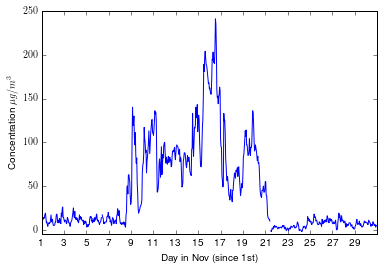

In [7]:
plt.figure()
SF['PM2.5'].plot()
labels = np.arange(1,31,2)
plt.xticks(np.arange(0, 720, 48), labels)
# labels = np.arange(1,30,1)
# plt.xticks(np.arange(0, 720, 24), labels)
plt.ylim([-5, 250])
plt.xlabel(r'Day in Nov (since 1st)')
plt.ylabel(r'Concentration $\mu g/m^3$')
# plotTimeS(SF, 'NOx')
plt.savefig('sf-pm.eps', format='eps', dpi=1000)
plt.show()

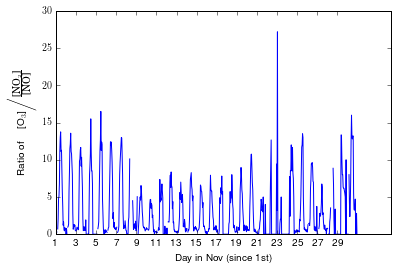

In [8]:
plt.plot(SF["O3"].div(SF["NO2"].div(SF["NO"])))
labels = np.arange(1,31,2)
plt.xticks(np.arange(0, 720, 48), labels)
plt.xlabel(r'Day in Nov (since 1st)')
plt.ylabel(r'Ratio of $\quad$[O$_3$]\Bigg /$\frac{\textrm{[NO}_2\textrm{]}}{\textrm{[NO]}}$')
# plt.xlabel(r'O_3')
# plt.ylabel(r'$[NO_2]/[NO]$')

plt.show()

#### Ozone calculation
Calculate the coefficient $k_1$.

##### Define reaction coefficients

In [19]:
k2 = 2.33*10**-5
k3 = 2.95*10
k4 = 1.38*10**4
k5 = 4.50*10**-3
k6 = 1.48*10**4
k7 = 2.34*10**-3
k8 = 7.62*10**-10
k9 = 4.43*10**3
k10 = 1.38*10**1
k11 = 0.46*10**-1

##### PSSA
Usage: **findk1PSSA(NO2, NO, O3)**

In [20]:
def findk1PSSA(NO2, NO, O3):
    M = 10**6
    O2 = 0.21*M
    O = O3*(k3*NO + k11*NO2) / (k2*O2*M)
    k1 = O*(k2*O2*M+k4*NO2+k5*NO2*M+k7*NO*M) / NO2
    return k1

In [21]:
findk1PSSA(0.04, 0.40, 9.99*10**-4) / k3

0.009994963836357524

##### Basic
Usage: **findk1Basic(NO2, NO, O3)**

In [22]:
def findk1Basic(NO2, NO, O3):
    k1 = O3*k3*NO/NO2
    return k1

In [23]:
findk1Basic(0.04, 0.40, 9.99*10**-4) / k3

0.009990000000000002

##### Apply to dataset

In [23]:
pssaK1 = SF[['NO2','NO','O3']].apply(lambda x: findk1PSSA(*x) / k3,axis=1)
basicK1 =  SF[['NO2','NO','O3']].apply(lambda x: findk1Basic(*x) /k3,axis=1)

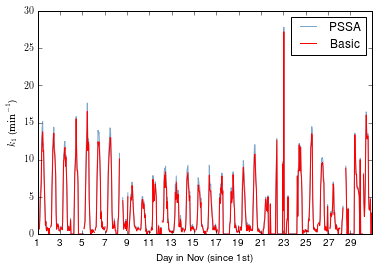

In [158]:
pssaK1.plot(color = 'steelblue', alpha = 0.7)
basicK1.plot(color = 'red')
labels = np.arange(1,31,2)
plt.xticks(np.arange(0, 720, 48), labels)
plt.xlabel(r'Day in Nov (since 1st)')
plt.ylabel(r'$k_1$ ($\textrm{min}^{-1}$)')
plt.legend(['PSSA','Basic'], loc = 'best')
plt.savefig('sf-k1.eps', format='eps', dpi=1000)
plt.show()

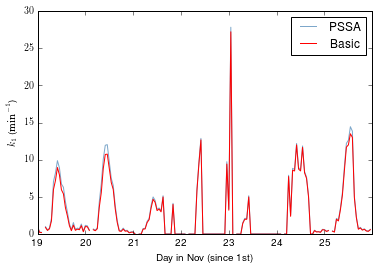

In [165]:
pssaK1.iloc[18*24:25*24].plot(color = 'steelblue', alpha = 0.7)
basicK1.iloc[18*24:25*24].plot(color = 'red')
labels = np.arange(19,26,1)
plt.xticks(np.arange(18*24,26*24, 24), labels)
plt.xlabel(r'Day in Nov (since 1st)')
plt.ylabel(r'$k_1$ ($\textrm{min}^{-1}$)')
plt.legend(['PSSA','Basic'], loc = 'best')
plt.savefig('sf-k1-zoom.eps', format='eps', dpi=1000)
plt.show()

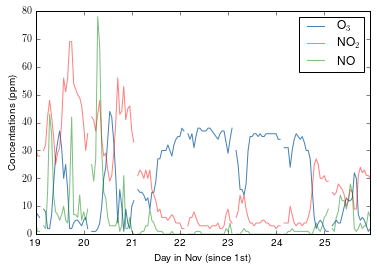

In [168]:
SF['O3'].iloc[18*24:25*24].plot(color = 'steelblue')
SF['NO2'].iloc[18*24:25*24].plot(color = 'red', alpha = 0.5)
SF['NO'].iloc[18*24:25*24].plot(color = 'green', alpha = 0.5)
# SF.iloc[20*24:25*24].plot(color = 'red')
labels = np.arange(19,26,1)
plt.xticks(np.arange(18*24,25*24, 24), labels)
plt.xlabel(r'Day in Nov (since 1st)')
plt.ylabel(r'Concentrations (ppm)')
plt.legend(['O$_3$','NO$_2$', 'NO'], loc = 'best')
plt.savefig('sf-o3-zoom.eps', format='eps', dpi=1000)
plt.show()

#### Weather data that can be used to validate our guess on Nov 22
Nov 22 has anomaly with NOx and O3

Guess it's NOx from the fire accumulated turned into O3 and there was rain for several days.
This created a high O3 environment.

https://www.timeanddate.com/weather/usa/san-francisco/historic?month=11&year=2018<br>
https://w2.weather.gov/climate/xmacis.php?wfo=mtr<br>

https://www.ozonesolutions.com/journal/2012/the-smell-of-rain-does-ozone-play-a-role/

#### Compare SF with last year

In [103]:
dayDF = {}
for day in range(18,25):
    url = "http://www.baaqmd.gov/about-air-quality/current-air-quality/air-monitoring-data?DataViewFormat=daily&DataView=tech&StartDate=11/{}/2017&ParameterId=&StationId=5011".format(day)
    dayDF[day] = download(url)
SF_2017 = copy.copy(dayDF[18])
for day in range(19, 25):
    SF_2017 = SF_2017.append(dayDF[day], ignore_index=True)

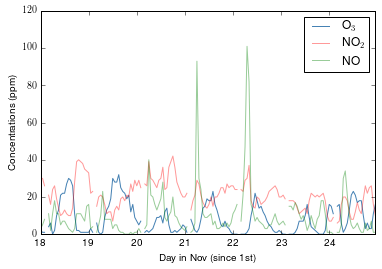

In [113]:
SF_2017['O3'].plot(color = 'steelblue')
SF_2017['NO2'].plot(color = 'red', alpha = 0.4)
SF_2017['NO'].plot(color = 'green', alpha = 0.4)
labels = np.arange(18,25,1)
plt.xticks(np.arange(0*24,7*24, 24), labels)
plt.xlabel(r'Day in Nov (since 1st)')
plt.ylabel(r'Concentrations (ppm)')
plt.legend(['O$_3$','NO$_2$', 'NO'], loc = 'best')
plt.show()

### Redwood city analysis

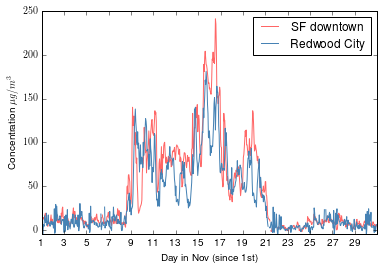

In [157]:
plt.figure()
SF['PM2.5'].plot(color = 'red', alpha = 0.6)
Redwood['PM2.5'].plot(color = 'steelblue')
labels = np.arange(1,30,2)
plt.xticks(np.arange(0, 720, 48), labels)
plt.ylim([-5, 250])
plt.xlabel(r'Day in Nov (since 1st)')
plt.ylabel(r'Concentration $\mu g/m^3$')
plt.legend(['SF downtown', 'Redwood City'], loc = 'best')
plt.savefig('pm.eps', format='eps', dpi=1000)
plt.show()

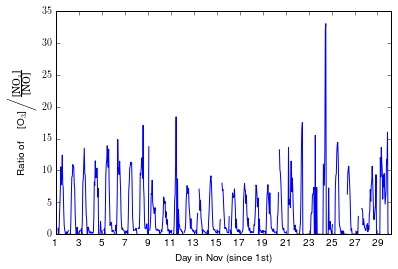

In [144]:
plt.plot(Redwood["O3"].div(Redwood["NO2"].div(Redwood["NO"])))
labels = np.arange(1,30,2)
plt.xticks(np.arange(0, 720, 48), labels)
plt.xlabel(r'Day in Nov (since 1st)')
plt.ylabel(r'Ratio of $\quad$[O$_3$]\Bigg /$\frac{\textrm{[NO}_2\textrm{]}}{\textrm{[NO]}}$')
# plt.xlabel(r'O_3')
# plt.ylabel(r'$[NO_2]/[NO]$')
plt.show()

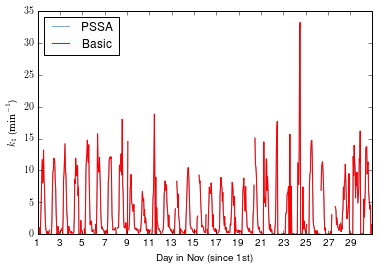

In [159]:
pK1 = Redwood[['NO2','NO','O3']].apply(lambda x: findk1PSSA(*x) / k3 if x['NO2'] != 0 else np.nan,axis=1)
bK1 =  Redwood[['NO2','NO','O3']].apply(lambda x: findk1Basic(*x) /k3 if x['NO2'] != 0 else np.nan,axis=1)
pK1.plot(color = 'steelblue', alpha = 0.7)
pK1.plot(color = 'red')
labels = np.arange(1,31,2)
plt.xticks(np.arange(0, 720, 48), labels)
plt.xlabel(r'Day in Nov (since 1st)')
plt.ylabel(r'$k_1$ ($\textrm{min}^{-1}$)')
plt.legend(['PSSA','Basic'], loc = 'best')
plt.savefig('redwood-k1.eps', format='eps', dpi=1000)
plt.show()

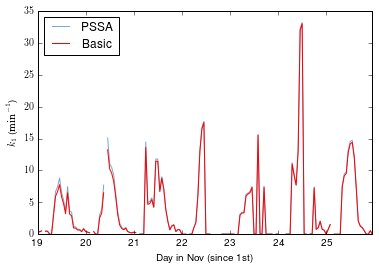

In [169]:
pK1.iloc[18*24:25*24].plot(color = 'steelblue', alpha = 0.7)
bK1.iloc[18*24:25*24].plot(color = 'red')
labels = np.arange(19,26,1)
plt.xticks(np.arange(18*24,25*24, 24), labels)
plt.xlabel(r'Day in Nov (since 1st)')
plt.ylabel(r'$k_1$ ($\textrm{min}^{-1}$)')
plt.legend(['PSSA','Basic'], loc = 'best')
plt.savefig('redwood-k1-zoom.eps', format='eps', dpi=1000)
plt.show()

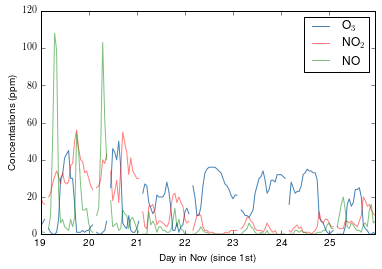

In [170]:
Redwood['O3'].iloc[18*24:25*24].plot(color = 'steelblue')
Redwood['NO2'].iloc[18*24:25*24].plot(color = 'red', alpha = 0.5)
Redwood['NO'].iloc[18*24:25*24].plot(color = 'green', alpha = 0.5)
# SF.iloc[20*24:25*24].plot(color = 'red')
labels = np.arange(19,26,1)
plt.xticks(np.arange(18*24,25*24, 24), labels)
plt.xlabel(r'Day in Nov (since 1st)')
plt.ylabel(r'Concentrations (ppm)')
plt.ylim([0,120])
plt.legend(['O$_3$','NO$_2$', 'NO'], loc = 'best')
plt.show()

### Regression analysis
Take daily maximums, to avoid noise.

#### SF

[-0.24316995  1.38857184]


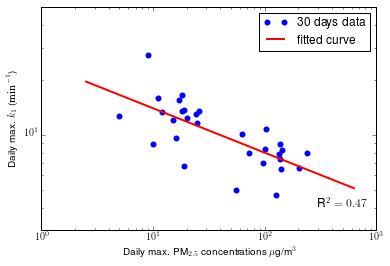

-0.93136295062690433

In [153]:
dayPM = []
for day in range(1, 31):
    dayPM.append(SF['PM2.5'].iloc[(day-1)*24: day*24].max())

# pssaK1.plot(color = 'steelblue', alpha = 0.7)
dayK1 = []
for day in range(1, 31):
    dayK1.append(basicK1.iloc[(day-1)*24: day*24].max())

coeff = np.polyfit(np.log10(dayPM), np.log10(dayK1), 1)
print(coeff)

dPoints = [pow(10, i)**coeff[0] * pow(10,coeff[1]) for i in np.arange(0.4,3,0.2)]
fig = plt.figure()
ax = plt.gca()
ax.plot(dayPM, dayK1, 'o', c='blue', markeredgecolor='none', label = '30 days data')
ax.plot([pow(10, i) for i in np.arange(0.4,3,0.2)], dPoints, color='red', lw=2, label = 'fitted curve')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'Daily max. PM$_{2.5}$ concentrations $\mu$g/m$^3$')
ax.set_ylabel(r'Daily max. $k_1$ ($\textrm{min}^{-1}$)')
ax.set_ylim((3,50))
ax.legend()
ax.text(300, 4, r'R$^2=0.47$', fontsize=12)
# ax.set_title('distribution of node out-degrees \nin wikiVoter network')
plt.savefig('sf-fit.eps', format='eps', dpi=1000)
plt.show()

residuals = np.log(dayK1) - np.log(np.power(np.log10(dayPM), 10)**coeff[0] * np.power(coeff[1],10))
ss_res = np.sum(residuals**2)
ss_tot = np.sum((np.log(dayK1)-np.mean(np.log(dayK1)))**2)
r_squared = 1 - (ss_res / ss_tot)
r_squared

slope, intercept, r_value, p_value, std_err = linregress(np.log(dayK1), np.log(np.power(np.log10(dayPM), 10)**coeff[0] * np.power(coeff[1],10)))
r_value**2

intercept

#### Redwood City

[-0.22764595  1.41690486]


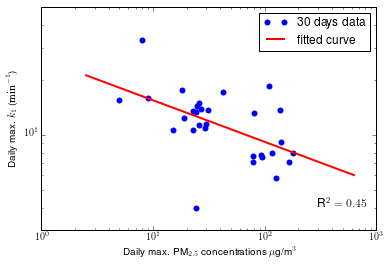

0.44906278438844849

In [154]:
pK1 = Redwood[['NO2','NO','O3']].apply(lambda x: findk1PSSA(*x) / k3 if x['NO2'] != 0 else np.nan,axis=1)
bK1 =  Redwood[['NO2','NO','O3']].apply(lambda x: findk1Basic(*x) /k3 if x['NO2'] != 0 else np.nan,axis=1)

dayPM = []
for day in range(1, 31):
    dayPM.append(Redwood['PM2.5'].iloc[(day-1)*24: day*24].max())

# pssaK1.plot(color = 'steelblue', alpha = 0.7)
dayK1 = []
for day in range(1, 31):
    dayK1.append(bK1.iloc[(day-1)*24: day*24].max())

coeff = np.polyfit(np.log10(dayPM), np.log10(dayK1), 1)
print(coeff)

dPoints = [pow(10, i)**coeff[0] * pow(10,coeff[1]) for i in np.arange(0.4,3,0.2)]
fig = plt.figure()
ax = plt.gca()
ax.plot(dayPM, dayK1, 'o', c='blue', markeredgecolor='none', label = '30 days data')
ax.plot([pow(10, i) for i in np.arange(0.4,3,0.2)], dPoints, color='red', lw=2, label = 'fitted curve')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'Daily max. PM$_{2.5}$ concentrations $\mu$g/m$^3$')
ax.set_ylabel(r'Daily max. $k_1$ ($\textrm{min}^{-1}$)')
ax.set_ylim((3,50))
ax.legend()
ax.text(300, 4, r'R$^2=0.45$', fontsize=12)
# ax.set_title('distribution of node out-degrees \nin wikiVoter network')
plt.savefig('redwood-fit.eps', format='eps', dpi=1000)
plt.show()

residuals = np.log(dayK1) - np.log(np.power(np.log10(dayPM), 10)**coeff[0] * np.power(coeff[1],10))
ss_res = np.sum(residuals**2)
ss_tot = np.sum((np.log(dayK1)-np.mean(np.log(dayK1)))**2)
r_squared = 1 - (ss_res / ss_tot)
r_squared

slope, intercept, r_value, p_value, std_err = linregress(np.log(dayK1), np.log(np.power(np.log10(dayPM), 10)**coeff[0] * np.power(coeff[1],10)))
r_value**2

intercept